# Laboratory #4_2 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification
*   Using pre-trained deep networks for feature extraction

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

**Authors**
- Joaquim Marset Alsina
- Jesús Molina Rodríguez de Vera

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import os
import numpy as np

from skimage.feature import ORB
from skimage.color import rgb2gray, gray2rgb
from skimage.io import imread
from scipy.cluster.vq import vq

from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import pandas as pd
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50

import cv2

## Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment. Upload the dataset to the drive and mount it.

In [3]:
# modify the dataset variable with the path from your drive

dataset_path = r'/content/drive/MyDrive/CV - Lab/Lab 8/101_ObjectCategories/'

In [4]:
categories = ['butterfly', 'kangaroo', 'dalmatian']
ncl = len(categories) * 10

*   Create a list of file and the corresponding labels

In [5]:
# solution
data = []
labels = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    file_names = os.listdir(folder_path)
    for file_name in file_names:
        image = imread(os.path.join(folder_path, file_name))
        data.append(image)
        labels.append(category)

data = np.array(data)
labels = np.array(labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [6]:
print('Total number of images:', len(data))

Total number of images: 244


*   Create a train / test split where the test is 10% of the total data

In [7]:
# solution
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=1234, stratify=labels)

In [8]:
print('Train set:', len(x_train))
print('Test set:', len(x_test))

Train set: 219
Test set: 25


*   How do you select the train/test split?

**Solution**

To split the data into train and test sets, we are using the sklearn function `train_test_split` that automatizes this process. This function works by randomly shuffling the data if the `shuffle` parameter is not set to `False`, and then dividing the data into at least 2 subsets (i.e. train and test). The size of the test subset is specified by the `test_size` parameter, which in this case we have decided to leave only a 10% of the data for testing given the small dataset we are working with. Given that we are performing a random shuffling, we are setting the `random_state` parameter to some value to ensure reproducibility every time we execute the code. Finally, we have the `stratify` parameter. We are dealing with a dataset containing 91 butterflies, 67 dalmatians, and 86 kangaroos. We have a bit of imbalance, especially with the dalmatians. For that reason, stratifying the split comes in handy, as it will keep the same proportion of instances of the 3 classes in both the train and test set. This way we are ensuring both datasets will contain enough data of all classes, which will help with the generalization ability of the model we build.

## Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 256 keypoints.


In [9]:
# solution
descriptor_extractor = ORB(n_keypoints=256)

*   Extract ORB descriptors from all the images in the train set.


In [10]:
# solution
def extract_descriptors(descriptor_extractor, image):
    if len(image.shape) != 2:
        gray_img = rgb2gray(image)
    else:
        gray_img = image
    descriptor_extractor.detect_and_extract(gray_img)
    return descriptor_extractor.descriptors

In [ ]:
train_descriptors = [extract_descriptors(descriptor_extractor, image) for image in x_train]

In [12]:
print(f'Size of each descriptor: {train_descriptors[0].shape[1]}')

Size of each descriptor: 256


In [13]:
# If we try to create a numpy array from the training descriptors we cannot.
# This is because there is an image with less than 256 keypoints
for i in range(len(train_descriptors)):
    if train_descriptors[i].shape != (256, 256):
        print(train_descriptors[i].shape)

(231, 256)


*   What is the size of the feature descriptors? What does each dimension represent in the feature descriptors?

**Solution**

As we explained in the previous lab that we worked with ORB, ORB is a combination of the FAST corner detection, and the BRIEF feature representation variation called rotated BRIEF. For each corner we found with FAST, we apply rotated BRIEF to obtain a binary vector of 256 positions representing that corner [ORB explanation](https://medium.com/data-breach/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf).

The idea of BRIEF is to consider a pair of pixels in the neighbourhood of the detected corner, and check their intensity. If the first one is brighter than the second, a 1 is added to the binary vector, and 0 otherwise. This process is repeated in this case 256 times to generate the final keypoint descriptor we will use to build the Bag of Words.
To obtain all these pixels, first, Gaussian smoothing is performed on the image to avoid generating a descriptor that is very sensitive to noise. Then, the first pixel of the pair is randomly drawn from a normal distribution centred in the keypoint, with a certain sigma. The second pixel is drawn from another normal distribution, now centred in the first pixel and with a spreading of the previous sigma divided by 2.

BRIEF has the problem of rotation variance, and steer BRIEF appears as an alternative to try and achieve the desired invariance property. Steer BRIEF works by taking into account the orientation of the patch around the keypoint where we extract the pixels to create the original BRIEF binary vector. It first creates a matrix $S$ containing all the pairs of pixels used to create the original BRIEF vector. Then, it finds the orientation of the patch and computes the corresponding rotation matrix $R\theta$, which is multiplied with the matrix $S$ to obtain the rotated version of $S$, $S\theta$. Given all the possible orientations, ORB discretizes the possible angle in increments of $\frac{2\pi}{30}$ degrees and constructs a lookup table. Then, if we have different possible orientations of the same keypoint, as long as it is consistent across different views, we will ensure to use the correct set of points $S\theta$ to compute the descriptor.

Steer BRIEF loses a desirable property BRIEF has that is that each feature has a large variance and a mean near 0.5, but once the rotation is applied we lose this property. Also, we want the different pixel intensity tests we do to generate each bit of the feature vector to be as uncorrelated as possible, permitting each test to contribute to the result.  
For this reason, appears rotated BRIEF. What it does is to perform a greedy search among all the pixel intensity tests that can be obtained from the different orientations of the patch containing a keypoint, keeping the ones with a mean near 0.5, most variance, and most uncorrelated as possible. [steer BRIEF and rotated BRIEF explanation](https://www.youtube.com/watch?v=FKi4ETjaTaU)

## Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use sklearn.cluster.MiniBatchKMeans for K-Means

In [ ]:
# solution
codebook = MiniBatchKMeans(n_clusters=ncl, random_state=1234)
# We apply a vertical stacking to fit to K-Means because of that image with fewer keypoints
codebook.fit(np.vstack(train_descriptors))

MiniBatchKMeans(n_clusters=30, random_state=1234)

*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.

In [ ]:
# solution
def compute_histograms(codebook, descriptors, n_clusters=ncl):
    histogram = np.zeros((len(descriptors), n_clusters), dtype='float32')

    for i in range(len(descriptors)):
        if len(descriptors[i].shape) == 1:
            codewords_i = codebook.predict(descriptors[i].reshape(1, -1))
        else:
            codewords_i = codebook.predict(descriptors[i])
        histogram[i, :] = np.histogram(codewords_i, ncl, range=(0, ncl-1), density=True)[0]

    return histogram

In [ ]:
train_histograms = compute_histograms(codebook, train_descriptors)


# Creating Classification Model

*   The next step is to create a classification model. We will use a C-Support Vector Classification for creating the model.



In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

*   Use GridSearchCV to find the optimal value of C and Gamma.

In [ ]:
# solution
def train_svc(X, y):
    parameters = {'kernel': ('linear', 'rbf'), 'C': np.arange(1, 10), 
                  'gamma': ['auto', 'scale']+np.linspace(0,2, 21).tolist()}
    grid_search = GridSearchCV(SVC(), parameters, cv=10)
    grid_search.fit(X, y)
    best_estimator = grid_search.best_estimator_
    print(f'Optimal params: {grid_search.best_params_}')
    print(f'10-fold Cross-Validation Accuracy: {grid_search.best_score_}')
    return best_estimator

best_model = train_svc(train_histograms, y_train)

Optimal params: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
10-fold Cross-Validation Accuracy: 0.6805194805194806


# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


In [ ]:
# solution
test_descriptors = np.array([extract_descriptors(descriptor_extractor, image) for image in x_test])

test_histograms = compute_histograms(codebook, test_descriptors)

test_predictions = best_model.predict(test_histograms)

*   Calculate the accuracy score for the classification model

In [ ]:
# solution
print(f'Test accuracy with best estimator: {accuracy_score(y_test, test_predictions)}')

Test accuracy with best estimator 0.8


*   Generate the confusion matrix for the classification model

In [ ]:
# solution
categories = ['butterfly', 'dalmatian', 'kangaroo']
cm = pd.DataFrame(confusion_matrix(y_test, test_predictions), index=categories, columns=categories)
print(cm)

           butterfly  dalmatian  kangaroo
butterfly          7          1         1
dalmatian          1          5         1
kangaroo           1          0         8


*   Why do we use Clustering to create the codebook? 
*   What are the other techniques that can be used to create the codebook?

**Solution**

We use clustering because we can have a lot of descriptors for similar image corners. For example, we can have in different images a descriptor representing a corner found in the eye of a person. In that case, we do not want to have different codewords representing a similar patch, given that we would end with a Bag of Words containing low-frequency values (i.e. a histogram with lots of bins but low frequencies), and possibly, a sparse vector. For this reason, we group them in clusters to generate a set of representative codewords that can be used to generate the subsequent set of features to be trained with SVM to classify images.

Other techniques used to create the codebook are:

**Linde Buzo Gray (LBG)**

The idea of this algorithm is to iteratively increase the size of the codebook by generating 2 new codewords for each one of the codewords of the previous iteration.
It starts by computing an average of all the image patches of the training set, considering it as the initial codeword. Then, it adds and subtracts a constant vector to this initial codeword to generate 2 new ones that will form the new codebook.

In this stage, we have a codebook consisting of 2 codewords, and the train patches are assigned to each codeword in the same fashion as K-Means by the minimum euclidean distance.

The process of generating 2 new codewords per each one of the previous codewords, and then assigning the train patches, is repeated until reaching the desired codebook size.

[LGB explained](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.259.828&rep=rep1&type=pdf)


**Pairwise Nearest Neighbour (PNN)**

It is a hierarchical agglomerative clustering approach. It starts by considering each possible image patch of the training set as a cluster (i.e. as many clusters as possible image patches), and iteratively it merges clusters until the desired final number of clusters is obtained. When merging 2 clusters, the algorithm will always merge those that are closest in terms of some distance function like euclidean ([PNN explained](https://www.researchgate.net/publication/27661047_Pairwise_Nearest_Neighbor_Method_Revisited)).

**Kekre’s Proportionate Error (KPE)**

The idea of this algorithm is similar to the one LBG uses, but the way it generates new codewords is slightly different.  
Therefore, it also starts with a codebook of size 1, and iteratively increase the size of the codebook by generating 2 new codewords for each one of the previous iterations.
It starts by computing the mean of all possible image patches of the training set. This mean will represent the initial codeword. An error vector is computed by using this first codeword, and 2 new codewords are generated by respectively adding and subtracting the error vector to the initial codeword.  

Then, the process is the same as with LBG, associating the train patches, and repeating the steps until achieving the desired codebook size or until reaching a minimum error. 

([KPE explained](https://www.researchgate.net/publication/265751061_Two-level_Vector_Quantization_Method_for_Codebook_Generation_using_Kekre's_Proportionate_Error_Algorithm))

There are other algorithms used to generate codebooks. In the same link where LGB is explained, there are other techniques.
Another technique we have not explained is the one presented [here](https://jmlr.org/papers/volume12/wu11b/wu11b.pdf).

*   Will adding more keypoints increase the performanc of the algorithm?

**Solution**

Increasing the number of extracted keypoints in each image will result in more descriptors that when later clustered with K-Means, will suppose more points associated with each cluster. In this case, we are not changing the number of clusters, so the number of histogram bins that will later serve as features to the SVC will not change either.  
The only change will be in the frequency of each codeword in the BoVW for each image (i.e. frequency of the different bins in the histogram), and given that we normalize them, will end up in smaller values, more closer to 0.

Besides, we have to take into account that increasing the number of desired keypoints will not necessarily mean that more keypoints will be extracted. We have already seen that with a particular image, the number of extracted keypoints was less than the expected 256.  
Therefore, we may need to tune the other ORB parameters to increase the number of keypoints.

In [ ]:
descriptor_extractor = ORB(n_keypoints=500)
image_descriptor = extract_descriptors(descriptor_extractor, x_train[0])
print(image_descriptor.shape)

(500, 256)


We see that in this case, we can obtain for a random image more descriptors by simply changing the parameter. Therefore, when trying to test the results we can obtain by increasing the number of descriptors, we will assume that only increasing that parameter will be enough.

In any case, we believe that in some cases it could be possible to improve the performance we could obtain with some image if the number of keypoints is not enough to extract some relevant patch that may be needed to correctly classify an image.

However, and overall, we believe that in this particular set of images, the performance will not significantly improve by adding more than the current 256 keypoints. We are going to check it in the following cell by repeating the previous computations, but changing the descriptor extractor:

In [ ]:
def test_orb_keypoints(n_keypoints, train_data, test_data, n_clusters=ncl):
    descriptor_extractor = ORB(n_keypoints=n_keypoints)

    train_descriptors = [extract_descriptors(descriptor_extractor, image) for image in train_data]
    test_descriptors = [extract_descriptors(descriptor_extractor, image) for image in test_data]

    codebook = MiniBatchKMeans(n_clusters=ncl, random_state=1234)
    codebook.fit(np.vstack(train_descriptors))

    train_histograms = compute_histograms(codebook, train_descriptors)
    test_histograms = compute_histograms(codebook, test_descriptors)

    return train_histograms, test_histograms

def train_test_svc(train_histograms, test_histograms, y_train, y_test):
    best_model = train_svc(train_histograms, y_train)
    test_predictions = best_model.predict(test_histograms)
    print(f'Test accuracy with best estimator: {accuracy_score(y_test, test_predictions)}')

In [ ]:
for n_keypoints in [100, 256, 300, 400]:
    print(f'Number of keypoints: {n_keypoints}')
    train_histograms, test_histograms = test_orb_keypoints(n_keypoints, x_train, x_test)
    train_test_svc(train_histograms, test_histograms, y_train, y_test)

    print()

Number of keypoints: 100
Optimal params: {'C': 9, 'gamma': 1.6, 'kernel': 'rbf'}
10-fold Cross-Validation Accuracy: 0.64004329004329
Test accuracy with best estimator: 0.56

Number of keypoints: 256
Optimal params: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
10-fold Cross-Validation Accuracy: 0.6805194805194806
Test accuracy with best estimator: 0.8

Number of keypoints: 300
Optimal params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
10-fold Cross-Validation Accuracy: 0.6764069264069263
Test accuracy with best estimator: 0.6

Number of keypoints: 400
Optimal params: {'C': 2, 'gamma': 1.7000000000000002, 'kernel': 'rbf'}
10-fold Cross-Validation Accuracy: 0.6625541125541126
Test accuracy with best estimator: 0.64



As we can see, with less than 256 keypoints we are not able to obtain a very good accuracy in the test set, compared to the initial one we obtained with 256 keypoints. We have to take into account that the test set is only composed of 25 images, and if we fail in a few examples we are already losing considerably accuracy.

We can see that by increasing the number over 256, we obtain a slight worsening in the train set. With the test set, we can see that there is no match with the one obtained with 256 keypoints.

# Extracting features from Deep Network

It is quite possible to extract features (similar to SIFT or ORB) from different layers of deep network.

*   Load ResNet50 model with imagenet weights and check the summary of the model
*   Create a model to extract features from the 'avg_pool' layer.
*   Extract features from the layer for all the train images.

In [ ]:
# solution
resnet = ResNet50(weights='imagenet')
print(resnet.summary())

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
avg_pool = resnet.get_layer('avg_pool').output
model = keras.Model(resnet.input, avg_pool)

In [ ]:
def extract_features_nn(image):
    if len(image.shape) == 2:
        return extract_features_nn(gray2rgb(image))
    else:
        # Resize image to Resnet50's input (224x224)
        image = cv2.resize(image, (224, 224))
        return model(image[None, :, :, :]) # Add batch dimension

descriptors_nn = np.array([extract_features_nn(image) for image in x_train]).squeeze()

*   What is the size of the feature descriptors?

In [ ]:
# solution
descriptors_nn.shape

(219, 2048)

*   Create codebook using the extracted features **(we don't use codebook according to professor's instructions)**

In [ ]:
# We don't do it as the professor told us not to use a codebook

*   Train SVM classifier using the codebook

In [ ]:
# solution
clf = train_svc(descriptors_nn, y_train)

Optimal params: {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
10-fold Cross-Validation Accuracy: 1.0


*   Evaluate the test set using the above method

In [ ]:
# solution
descriptors_test_nn = np.array([extract_features_nn(x_test[i]) for i in range(len(x_test))]).squeeze()
predictions_test = clf.predict(descriptors_test_nn)

*   Calculate the accuracy score and confusion matrix for the classification model

In [ ]:
# solution
print("Test Accuracy: ", np.mean(y_test == predictions_test))

cm = pd.DataFrame(confusion_matrix(y_test, predictions_test), index=categories, columns=categories)
print(cm)


Test Accuracy:  1.0
           butterfly  dalmatian  kangaroo
butterfly          9          0         0
dalmatian          0          7         0
kangaroo           0          0         9


*   Compare the performance of both the BoVW models. Which model works better and why?

**Solution**

As we can see (accuracy and confusion matrix), the neural network performs much better than the ORB-based solution. Indeed, the SVC trained with the features of the CNN gets a 100% accuracy, meaning that it classifies correctly all the images in the test set.

Better performance of CNN was to be expected, as solutions based on this technology have become SOTA for most computer vision problems in the last few years. This superior ability can be explained by different factors. On the one hand, being the CNN completely trained, it depends less on handcrafted rules and human expertise, so it is more adaptable and capable to find the really interesting features from an image. On the other hand, in this case, the final feature vector used for the classification is greater than in the case of the ORB-based solution. Therefore, the CNN vector has more expressivity. However, as we will see in the last exercise, 2 dimensions are enough to "separate" the three classes.

*   Can the performance of pre-trained model increased further? If so, how?

**Solution**

Given that we are getting 100% accuracy, evaluating improvements of the model would be nearly impossible with the same dataset. If we had a big enough test set, such comparison would be enabled.

In a situation like that, if the performance of the model was not good enough, we could explore different alternatives:
- Avoiding the usage of SVM as a classifier and replacing the final layers of the network with a classifier MLP with 3 output nodes (because we have three classes). Then we could finetune those last layers to adapt them to predict the new classes based on the already found features (previous layers, which would be "frozen").
- It could also be possible to allow other layers to be updated during the new training process.
- We could increase (artificially) the size of our training set by using different data augmentation techniques, such as rotations, cropping, padding...

There are a lot of possibilities. However, the best one would depend on the particular situation, but it is not our case.

*   What happens if the test image does not belong to any of the trained classes?

**Solution**

In the case that the image does not belong to any of the considered classes, the classifier won't be able to detect it. This classifier has been only trained to choose one of the three options, so it will pick an answer from those classes even if the image is from a completely different object.

*   Combine the features extracted using ORB and Deep Neural Network.
*   Create a codebook with the combined features
*   Train a SVM classifier using the generated codebook and evaluate the performance using accuracy and confusion matrix.

In [ ]:
# solution
descriptors = np.hstack([train_histograms, descriptors_nn])
descriptors_test = np.hstack([test_histograms, descriptors_test_nn])

# We assume that here, as we have 1 single vector for every image (like with the ResNet) a new codebook should not be used
clf = train_svc(descriptors, y_train)
predictions_test = clf.predict(descriptors_test)

print("Test Accuracy: ", np.mean(y_test == predictions_test))

cm = pd.DataFrame(confusion_matrix(y_test, predictions_test), index=categories, columns=categories)
print(cm)

Optimal params: {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
10-fold Cross-Validation Accuracy: 1.0
Test Accuracy:  1.0
           butterfly  dalmatian  kangaroo
butterfly          9          0         0
dalmatian          0          7         0
kangaroo           0          0         9


*   Do the combined features increase the performance of the classifier?

**Solution**

According to the professor's instructions, we are concatenating the histogram computed from the ORB's output and the output of the average pooling layer of the ResNet. Thus, we obtain a single one-dimension vector per image, and we train an SVC to classify the images from that combined vector.

As we can see, the performance of this combined model is the same as the approach based only on ResNet. That is, it makes no mistakes in the test set. However, given that the previous model (only CNN) was simpler, we think that with the information we have it is better to use it (Occam's razor).

## t-distributed Stochastic Neighbor Embedding (Optional).

In order to visualize the features of a higher dimension data, t-SNE is used. t-SNE converts the affinities of the data points to probabilities. It recreates the probability distribution in a low-dimensional space. It is very helpful in visualizing features of different layers in a neural network.

You can find more information about t-SNE [here](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


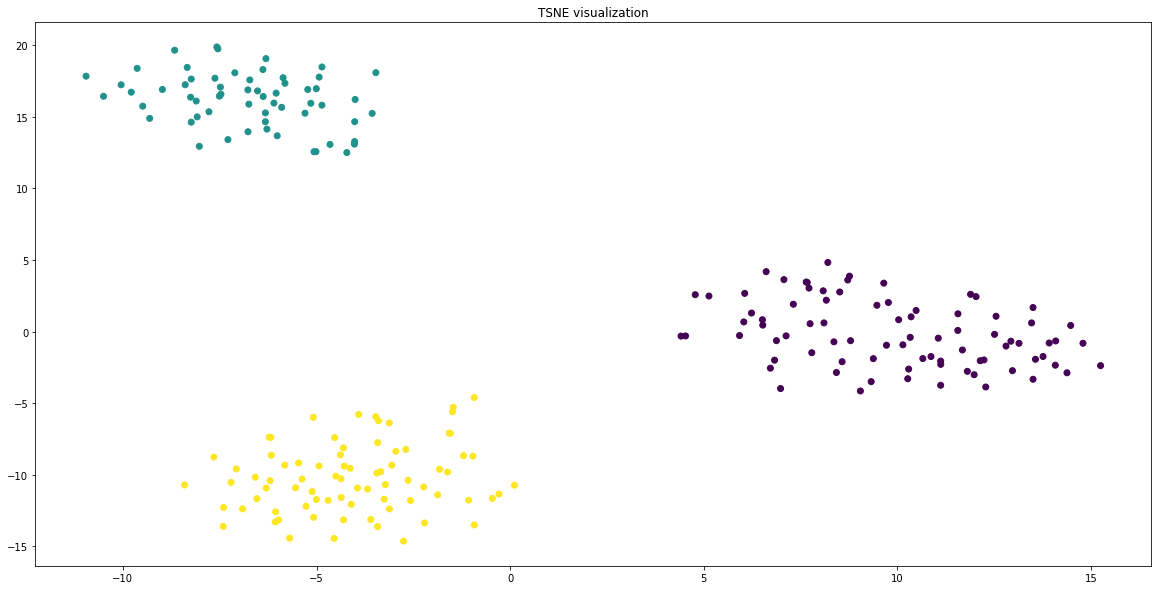

In [ ]:
from sklearn.manifold import TSNE
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_train)

model = TSNE(n_components=2, random_state=0)

np.set_printoptions(suppress=True)

low_embedding = model.fit_transform(descriptors_nn) 

plt.figure(figsize=(20,10))
plt.scatter(low_embedding[:, 0], low_embedding[:, 1], c=le.transform(y_train))
plt.title("TSNE visualization")
plt.show()

*   What do you infer from the t-SNE plot?

**Solution**

Please note that we have decided to use the feature vectors created by the CNN as input for the t-SNE algorithm as they achieve perfect accuracy in the test set.

In the plot, we can see that the instances belonging to the same class occupy the same area in the low dimensional space. Indeed, there are three well-defined clusters.

From that fact, we can infer that in the higher dimensional space there is a similar pattern, that is, points of the same class are close to each other but far from points of the other two classes. That makes sense, as we have seen that it is possible to find a classifier that properly separates those classes.


---

## **End of P4_2: Image Classification using Bag of Visual Words**
Deadline for P4_2 submission in CampusVirtual is: **Monday, the 6th of December, 2021**